<a href="https://colab.research.google.com/github/sriksmachi/sriksml/blob/main/reinforcement-learning/reinforce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforce Algorithm

## Introduction

The goal of an agent in Reinforcement learning is to learn optimal behaviour in an environment with an objective to maximize expected rewards.

Reinforcement learning problems can be broadly classified into policy based and value based methods. In value based methods, the agent learns value of an state or state-action pair at every point. The agent then uses those values to maximize the expected rewards. In a way, this is deterministic approach because after the values are learnt, there is no randomness exhibited by the agent to take learn new trajectories.
In contrast, in policy based methods the agent learns the probability distribution of actions that can be taken in a given time step, it then can stochasticaly choose action from the given distribution.

Reinforce (also called monte carlo variation of policy gradient) is a easy and simple to understand RL algorithm that belongs to policy gradient class of algorithms. Policy gradient methods attempt to learn the optimal policy, that is the probability distribution of action that can be taken in every state.
Compared to deterministic algorithms like DQL, stochastic methods like reinforce have an advantage of avoiding abrupt jumps in actions taken for small gradient updates. Since the model is dealing with probabilities of the actions, for smaller gradients the impact on probabilities is also small.

In this notebook you will learn Reinforce algorithm, using a sample built using GYM environment.

Paper Link : [REINFORCE](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)


## Intuition

The fundamental idea in reinforce algorithm is - To optimize the expected reward, we can gather trajectories (for both episodic and continuous and continuous tasks) and compute the expected reward for each trajectory.

We can then train a model using the trajectories and expected return for each trajectory such that it reinforces the good actions because good actions lead to higher returns.

Similarly, it tends to push down the probabilities of bad actions. Eventually the model learns only the good actions leading to learning the optimal policy.

Hence the loss function for the model is a product of probability of taking an action and the expected reward.


## Algorithm

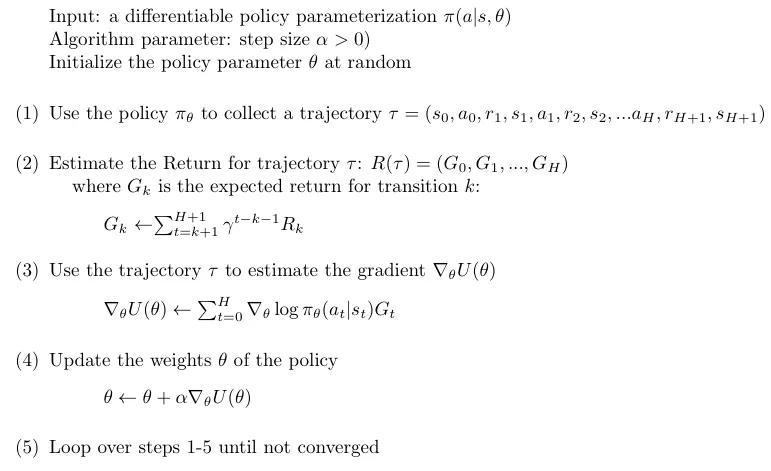

## Training process
The agent goes through following steps
- The model is initialized with initial random weights that acts as an initial policy.
- The agent acts on the environment and collects - next state, reward, action.
- The agents continuous to take action on the environment until it reaches the end state.
- The next state, reward and the action taken are used to calculate the rewards obtained per episode/trajectory.
- The model weights are updated using gradient ascent.
- These steps are repeated until the model converges.

## Code

In [ ]:
# hide output
!pip install renderlab > /dev/null 2>&1

In [ ]:
import gymnasium as gym
import renderlab as rl

def wrap_env(env):
    env = rl.RenderFrame(env, "./output")
    return env

In [ ]:
import tensorflow as tf
import numpy as np
import gym
import tensorflow_probability as tfp
from tqdm import tqdm

  if (distutils.version.LooseVersion(tf.__version__) <



In [1]:
env = gym.make('CartPole-v0')
env.reset()
terminal = False
rewards = []
while not terminal:
  action = env.action_space.sample()
  observation, reward, terminal, info = env.step(action)
  rewards.append(reward)
print(np.sum(rewards))


NameError: ignored

In [ ]:
low = env.observation_space.low
high = env.observation_space.high
print(f'Number of action spaces:  {env.action_space.n}')

Number of action spaces:  2


In [ ]:
class model(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.d1 = tf.keras.layers.Dense(64,activation='relu')
    self.d2 = tf.keras.layers.Dense(64,activation='relu')
    self.out = tf.keras.layers.Dense(env.action_space.n,activation='softmax')

  def call(self, input_data):
    x = tf.convert_to_tensor(input_data)
    x = self.d1(x)
    x = self.d2(x)
    x = self.out(x)
    return x

In [ ]:
class agent():
  def __init__(self, learning_rate=0.001, gamma=0.99):
    self.model = model()
    self.opt = tf.keras.optimizers.Adam(learning_rate)
    self.gamma = gamma

  def act(self,state):
    prob = self.model(np.array([state]))
    dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32)
    action = dist.sample()
    return int(action.numpy()[0])

  def a_loss(self,prob, action, reward):
    dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32)
    log_prob = dist.log_prob(action)
    # as expalined above the loss is the log probability & reward, since it is gradient ascent the loss is marked negative.
    # If reward is 1, the loss is lower than the case when reward is 0
    loss = -log_prob*reward
    return loss

  def train(self, states, rewards, actions):
    sum_reward = 0
    discnt_rewards = []
    rewards.reverse()
    for r in rewards:
      sum_reward = r + self.gamma * sum_reward
      discnt_rewards.append(sum_reward)
    discnt_rewards.reverse()

    for state, reward, action in zip(states, discnt_rewards, actions):
      with tf.GradientTape() as tape:
        # forward pass
        p = self.model(np.array([state]), training=True)
        # compute loss
        loss = self.a_loss(p, action, reward)
      # compute gradients
      grads = tape.gradient(loss, self.model.trainable_variables)
      # update weights
      self.opt.apply_gradients(zip(grads, self.model.trainable_variables))

In [ ]:
# params
learning_rate = 0.001
gamma = 0.99

cartpole = agent(learning_rate, gamma)
max_trajectories = 500
rewards_tracked = []
for trajectory in tqdm(range(max_trajectories)):
  done = False
  state = env.reset()
  total_reward = 0
  rewards = []
  states = []
  actions = []
  while not done:
    action = cartpole.act(state)
    next_state, reward, done, info = env.step(action)
    rewards.append(reward)
    states.append(state)
    actions.append(action)
    state = next_state
    total_reward += reward
    if done:
      cartpole.train(states, rewards, actions)
      if trajectory % 100 == 0 and trajectory > 0:
        print('Trajectory {}\tAverage Score: {:.2f}'.format(trajectory, total_reward))
      rewards_tracked.append(total_reward)

  5%|▌         | 101/2000 [02:51<20:36,  1.54it/s]

Trajectory 100	Average Score: 15.00


 10%|█         | 201/2000 [07:38<1:42:44,  3.43s/it]

Trajectory 200	Average Score: 189.00


 15%|█▌        | 301/2000 [12:51<1:32:56,  3.28s/it]

Trajectory 300	Average Score: 177.00


 20%|██        | 401/2000 [16:28<50:36,  1.90s/it]

Trajectory 400	Average Score: 154.00


 25%|██▌       | 501/2000 [20:21<1:23:05,  3.33s/it]

Trajectory 500	Average Score: 196.00


 30%|███       | 601/2000 [24:15<28:57,  1.24s/it]

Trajectory 600	Average Score: 10.00


 35%|███▌      | 701/2000 [26:30<24:40,  1.14s/it]

Trajectory 700	Average Score: 17.00


 40%|███▉      | 794/2000 [29:59<43:09,  2.15s/it]

## Analysis

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
x_axis = np.asarray(range(0, max_trajectories))
y_axis = np.asarray(rewards_tracked)
plt.figure(0, figsize=(16,4))
plt.title('Rewards per episode')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.plot(x_axis,y_axis,'green')
plt.grid()
plt.show()